## Imports and Initialization

In [1]:
#!pip install sympy==1.12 --force-reinstall

In [2]:
#import torchvision
#print(torchvision.__version__)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Prep

In [5]:
data_prefix = './datasets'

In [6]:
NUM_TRAIN = 49000
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar100_train = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar100_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar100_val = datasets.CIFAR100(data_prefix, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar100_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar100_test = datasets.CIFAR100(data_prefix, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar100_test, batch_size=64)

100%|██████████| 169M/169M [00:02<00:00, 57.1MB/s]


In [7]:
cifar100_train[0][0].shape

torch.Size([3, 32, 32])

## CNN Model

In [8]:
# RegDeepCNN(channels_list, pool_list)
# Flexible CNN with variable conv layers and optional 2x2 max pooling per layer.
# Args:
#  - channels_list (list of int): output channels per conv layer.
#  - pool_list (list of bool): whether to apply max pooling after each conv.
# Constraints:
#  - Input: 32x32 RGB images.
#  - Max pooling auto-disabled if it reduces spatial size below 4x4.
#  - channels_list and pool_list must be same length.
#  - Max 3 poolings allowed to keep spatial size ≥4x4.
# Example:
#  channels = [32,32,64,64]; pools = [False,True,False,True]
#  model = RegDeepCNN(channels, pools)
#  output = model(torch.randn(1,3,32,32))

In [9]:
class RegDeepCNN(nn.Module):
    def __init__(self, channels_list, pool_list):
        super(RegDeepCNN, self).__init__()

        assert len(channels_list) == len(pool_list), "channels_list and pool_list must be the same length"
        assert sum(pool_list) <= 3, "Too many poolings; spatial size < 4x4"

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.pool_bools = pool_list
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        in_channels = 3  # input RGB images

        for out_channels in channels_list:
            self.convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.bns.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels

        # After conv layers, define a linear layer.
        # To calculate the input size for linear layer, you need to know the spatial size after conv+pool layers.
        # For example, assuming input 32x32 and each maxpool halves size:
        num_pools = sum(pool_list)
        final_spatial_size = 32 // (2 ** num_pools)
        final_channels = channels_list[-1]
        self.linear = nn.Linear(final_channels * final_spatial_size * final_spatial_size, 100)

    def forward(self, x):
        for conv, bn, do_pool in zip(self.convs, self.bns, self.pool_bools):
            x = conv(x)
            x = bn(x)
            x = F.relu(x)
            if do_pool:
                x = self.pool(x)

        x = F.dropout(x, p=0.5)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


## Training

In [10]:
from tqdm import tqdm

### Accuracy and Loss Calculation Func

In [11]:
def check_accuracy_and_loss(loader, model, device):
    acc = 0
    total_loss = 0
    model.eval()
    num_correct = 0
    num_samples = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)
            total_loss += loss
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = num_correct / num_samples
    total_loss /= len(loader)
    return acc, total_loss

### Training func

In [12]:
def train_model(model, loader_train, loader_val, optimizer, criterion, epochs, device):
    best_val_loss = float('inf')
    best_model_wts = None

    model.to(device)

    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        epoch_loss = 0  # Accumulate loss for display
        epoch_steps = 0  # Count steps for loss averaging

        # Progress bar for training batches
        with tqdm(total=len(loader_train), desc=f"Training Epoch {epoch + 1}") as pbar:
            for x, y in loader_train:
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                scores = model(x)
                loss = criterion(scores, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress
                epoch_loss += loss.item()
                epoch_steps += 1
                pbar.set_postfix({"Batch Loss": loss.item()})
                pbar.update(1)

        train_acc, train_loss = check_accuracy_and_loss(loader_train, model, device=DEVICE)
        val_acc, val_loss = check_accuracy_and_loss(loader_val, model, device=DEVICE)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()

        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2%}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")

    # returning best and final model
    final_model_wts = model.state_dict().copy()  # save final weights
    model.load_state_dict(best_model_wts)       # load best weights
    return best_model_wts, final_model_wts, train_accs, val_accs, train_losses, val_losses

### Testing different architecture and hyperparameter configs

In [13]:
lr = 1e-3
epochs = 15

configs = [
    # deeper network, max allowed pooling
    {'channels': [64, 128, 256, 256], 'pools': [False, True, True, True]},
    # deeper network, max allowed pooling
    {'channels': [64, 128, 256, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'channels': [64, 128, 128, 256], 'pools': [False, True, False, True]},
    # deeper network, max allowed pooling
    {'channels': [64, 64, 128, 128, 256], 'pools': [False, True, False, True, False]}
]

results = []

for mc in configs:
    print(f"\nTraining model with channels={mc['channels']}, pools={mc['pools']}")

    model = RegDeepCNN(mc['channels'], mc['pools'])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # Adjust train_model to return best and final weights plus metrics
    best_wts, final_wts, train_accs, val_accs, train_losses, val_losses = train_model(
        model, loader_train, loader_val, optimizer, criterion, epochs=epochs, device=DEVICE)

    results.append({
        'channels': mc['channels'],
        'pools': mc['pools'],
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_weights': best_wts,
        'final_weights': final_wts,
    })


Training model with channels=[64, 128, 256, 256], pools=[False, True, True, True]
Epoch 1/15


Training Epoch 1: 100%|██████████| 766/766 [00:25<00:00, 29.59it/s, Batch Loss=3.22]


Epoch 1 - Train Loss: 2.8997, Train Acc: 28.12%, Val Loss: 3.0506, Val Acc: 26.40%
Epoch 2/15


Training Epoch 2: 100%|██████████| 766/766 [00:23<00:00, 32.46it/s, Batch Loss=2.61]


Epoch 2 - Train Loss: 2.1502, Train Acc: 43.66%, Val Loss: 2.4160, Val Acc: 37.70%
Epoch 3/15


Training Epoch 3: 100%|██████████| 766/766 [00:24<00:00, 31.07it/s, Batch Loss=2.01]


Epoch 3 - Train Loss: 1.7792, Train Acc: 52.39%, Val Loss: 2.1490, Val Acc: 45.70%
Epoch 4/15


Training Epoch 4: 100%|██████████| 766/766 [00:24<00:00, 30.87it/s, Batch Loss=1.85]


Epoch 4 - Train Loss: 1.5086, Train Acc: 59.01%, Val Loss: 2.0604, Val Acc: 45.20%
Epoch 5/15


Training Epoch 5: 100%|██████████| 766/766 [00:24<00:00, 31.01it/s, Batch Loss=1.84]


Epoch 5 - Train Loss: 1.2597, Train Acc: 65.28%, Val Loss: 2.0299, Val Acc: 46.50%
Epoch 6/15


Training Epoch 6: 100%|██████████| 766/766 [00:24<00:00, 30.76it/s, Batch Loss=1.38]


Epoch 6 - Train Loss: 1.0830, Train Acc: 69.60%, Val Loss: 2.0520, Val Acc: 46.70%
Epoch 7/15


Training Epoch 7: 100%|██████████| 766/766 [00:24<00:00, 31.58it/s, Batch Loss=1.18]


Epoch 7 - Train Loss: 0.8516, Train Acc: 75.21%, Val Loss: 2.0331, Val Acc: 49.20%
Epoch 8/15


Training Epoch 8: 100%|██████████| 766/766 [00:24<00:00, 31.29it/s, Batch Loss=1.04]


Epoch 8 - Train Loss: 0.7617, Train Acc: 77.21%, Val Loss: 2.1408, Val Acc: 47.40%
Epoch 9/15


Training Epoch 9: 100%|██████████| 766/766 [00:24<00:00, 31.01it/s, Batch Loss=0.808]


Epoch 9 - Train Loss: 0.6351, Train Acc: 81.04%, Val Loss: 2.2221, Val Acc: 48.70%
Epoch 10/15


Training Epoch 10: 100%|██████████| 766/766 [00:24<00:00, 31.11it/s, Batch Loss=0.702]


Epoch 10 - Train Loss: 0.5546, Train Acc: 83.03%, Val Loss: 2.4105, Val Acc: 49.30%
Epoch 11/15


Training Epoch 11: 100%|██████████| 766/766 [00:24<00:00, 31.17it/s, Batch Loss=1]


Epoch 11 - Train Loss: 0.4901, Train Acc: 84.76%, Val Loss: 2.5196, Val Acc: 48.70%
Epoch 12/15


Training Epoch 12: 100%|██████████| 766/766 [00:24<00:00, 30.82it/s, Batch Loss=0.82]


Epoch 12 - Train Loss: 0.4613, Train Acc: 85.42%, Val Loss: 2.6709, Val Acc: 46.60%
Epoch 13/15


Training Epoch 13: 100%|██████████| 766/766 [00:24<00:00, 31.16it/s, Batch Loss=0.662]


Epoch 13 - Train Loss: 0.4064, Train Acc: 87.05%, Val Loss: 2.6415, Val Acc: 47.30%
Epoch 14/15


Training Epoch 14: 100%|██████████| 766/766 [00:24<00:00, 31.03it/s, Batch Loss=0.782]


Epoch 14 - Train Loss: 0.3898, Train Acc: 87.43%, Val Loss: 2.6319, Val Acc: 48.40%
Epoch 15/15


Training Epoch 15: 100%|██████████| 766/766 [00:24<00:00, 31.05it/s, Batch Loss=0.389]


Epoch 15 - Train Loss: 0.3382, Train Acc: 89.07%, Val Loss: 2.9821, Val Acc: 47.20%

Training model with channels=[64, 128, 256, 256], pools=[False, True, False, True]
Epoch 1/15


Training Epoch 1: 100%|██████████| 766/766 [00:29<00:00, 26.38it/s, Batch Loss=2.14]


Epoch 1 - Train Loss: 2.8273, Train Acc: 30.40%, Val Loss: 2.9018, Val Acc: 27.90%
Epoch 2/15


Training Epoch 2: 100%|██████████| 766/766 [00:27<00:00, 27.56it/s, Batch Loss=2.13]


Epoch 2 - Train Loss: 2.0624, Train Acc: 46.43%, Val Loss: 2.4201, Val Acc: 38.90%
Epoch 3/15


Training Epoch 3: 100%|██████████| 766/766 [00:27<00:00, 27.43it/s, Batch Loss=1.88]


Epoch 3 - Train Loss: 1.5942, Train Acc: 58.19%, Val Loss: 2.1956, Val Acc: 44.20%
Epoch 4/15


Training Epoch 4: 100%|██████████| 766/766 [00:27<00:00, 27.53it/s, Batch Loss=1.8]


Epoch 4 - Train Loss: 1.1625, Train Acc: 68.20%, Val Loss: 2.1489, Val Acc: 46.20%
Epoch 5/15


Training Epoch 5: 100%|██████████| 766/766 [00:27<00:00, 27.61it/s, Batch Loss=1.06]


Epoch 5 - Train Loss: 0.8332, Train Acc: 76.68%, Val Loss: 2.1387, Val Acc: 48.00%
Epoch 6/15


Training Epoch 6: 100%|██████████| 766/766 [00:27<00:00, 27.40it/s, Batch Loss=1.08]


Epoch 6 - Train Loss: 0.6229, Train Acc: 82.07%, Val Loss: 2.3503, Val Acc: 45.20%
Epoch 7/15


Training Epoch 7: 100%|██████████| 766/766 [00:27<00:00, 27.71it/s, Batch Loss=0.961]


Epoch 7 - Train Loss: 0.4503, Train Acc: 86.43%, Val Loss: 2.5164, Val Acc: 46.80%
Epoch 8/15


Training Epoch 8: 100%|██████████| 766/766 [00:27<00:00, 27.71it/s, Batch Loss=0.806]


Epoch 8 - Train Loss: 0.3883, Train Acc: 87.97%, Val Loss: 2.7215, Val Acc: 46.00%
Epoch 9/15


Training Epoch 9: 100%|██████████| 766/766 [00:28<00:00, 27.29it/s, Batch Loss=0.724]


Epoch 9 - Train Loss: 0.3215, Train Acc: 89.92%, Val Loss: 2.8322, Val Acc: 47.80%
Epoch 10/15


Training Epoch 10: 100%|██████████| 766/766 [00:27<00:00, 28.13it/s, Batch Loss=0.211]


Epoch 10 - Train Loss: 0.2689, Train Acc: 91.46%, Val Loss: 3.0481, Val Acc: 46.60%
Epoch 11/15


Training Epoch 11: 100%|██████████| 766/766 [00:26<00:00, 28.42it/s, Batch Loss=1.03]


Epoch 11 - Train Loss: 0.2338, Train Acc: 92.49%, Val Loss: 3.2603, Val Acc: 45.90%
Epoch 12/15


Training Epoch 12: 100%|██████████| 766/766 [00:28<00:00, 27.34it/s, Batch Loss=0.36]


Epoch 12 - Train Loss: 0.2477, Train Acc: 92.14%, Val Loss: 3.2716, Val Acc: 45.00%
Epoch 13/15


Training Epoch 13: 100%|██████████| 766/766 [00:27<00:00, 27.77it/s, Batch Loss=0.281]


Epoch 13 - Train Loss: 0.2272, Train Acc: 92.65%, Val Loss: 3.3740, Val Acc: 45.60%
Epoch 14/15


Training Epoch 14: 100%|██████████| 766/766 [00:27<00:00, 27.49it/s, Batch Loss=0.0908]


Epoch 14 - Train Loss: 0.2042, Train Acc: 93.49%, Val Loss: 3.4726, Val Acc: 45.10%
Epoch 15/15


Training Epoch 15: 100%|██████████| 766/766 [00:27<00:00, 27.40it/s, Batch Loss=0.236]


Epoch 15 - Train Loss: 0.2030, Train Acc: 93.48%, Val Loss: 3.3738, Val Acc: 45.30%

Training model with channels=[64, 128, 128, 256], pools=[False, True, False, True]
Epoch 1/15


Training Epoch 1: 100%|██████████| 766/766 [00:25<00:00, 29.74it/s, Batch Loss=2.67]


Epoch 1 - Train Loss: 2.8545, Train Acc: 29.94%, Val Loss: 3.0011, Val Acc: 27.80%
Epoch 2/15


Training Epoch 2: 100%|██████████| 766/766 [00:25<00:00, 30.41it/s, Batch Loss=2.58]


Epoch 2 - Train Loss: 2.1622, Train Acc: 44.31%, Val Loss: 2.4833, Val Acc: 38.20%
Epoch 3/15


Training Epoch 3: 100%|██████████| 766/766 [00:25<00:00, 29.71it/s, Batch Loss=1.6]


Epoch 3 - Train Loss: 1.6957, Train Acc: 55.84%, Val Loss: 2.2204, Val Acc: 42.50%
Epoch 4/15


Training Epoch 4: 100%|██████████| 766/766 [00:25<00:00, 30.20it/s, Batch Loss=1.98]


Epoch 4 - Train Loss: 1.3057, Train Acc: 65.09%, Val Loss: 2.1966, Val Acc: 43.40%
Epoch 5/15


Training Epoch 5: 100%|██████████| 766/766 [00:25<00:00, 30.58it/s, Batch Loss=1.53]


Epoch 5 - Train Loss: 0.9687, Train Acc: 73.30%, Val Loss: 2.2617, Val Acc: 44.40%
Epoch 6/15


Training Epoch 6: 100%|██████████| 766/766 [00:25<00:00, 30.00it/s, Batch Loss=1.23]


Epoch 6 - Train Loss: 0.7158, Train Acc: 79.75%, Val Loss: 2.4603, Val Acc: 43.70%
Epoch 7/15


Training Epoch 7: 100%|██████████| 766/766 [00:25<00:00, 30.16it/s, Batch Loss=1.28]


Epoch 7 - Train Loss: 0.5392, Train Acc: 84.00%, Val Loss: 2.5570, Val Acc: 44.00%
Epoch 8/15


Training Epoch 8: 100%|██████████| 766/766 [00:25<00:00, 30.17it/s, Batch Loss=0.602]


Epoch 8 - Train Loss: 0.4216, Train Acc: 87.05%, Val Loss: 2.7863, Val Acc: 45.70%
Epoch 9/15


Training Epoch 9: 100%|██████████| 766/766 [00:25<00:00, 29.98it/s, Batch Loss=0.506]


Epoch 9 - Train Loss: 0.3438, Train Acc: 89.26%, Val Loss: 2.9169, Val Acc: 44.20%
Epoch 10/15


Training Epoch 10: 100%|██████████| 766/766 [00:25<00:00, 30.22it/s, Batch Loss=0.29]


Epoch 10 - Train Loss: 0.3087, Train Acc: 90.21%, Val Loss: 3.0305, Val Acc: 44.00%
Epoch 11/15


Training Epoch 11: 100%|██████████| 766/766 [00:25<00:00, 30.08it/s, Batch Loss=0.502]


Epoch 11 - Train Loss: 0.2833, Train Acc: 90.85%, Val Loss: 3.1800, Val Acc: 44.80%
Epoch 12/15


Training Epoch 12: 100%|██████████| 766/766 [00:25<00:00, 29.99it/s, Batch Loss=0.408]


Epoch 12 - Train Loss: 0.2431, Train Acc: 92.13%, Val Loss: 3.4946, Val Acc: 43.90%
Epoch 13/15


Training Epoch 13: 100%|██████████| 766/766 [00:25<00:00, 30.24it/s, Batch Loss=0.461]


Epoch 13 - Train Loss: 0.2276, Train Acc: 92.64%, Val Loss: 3.4846, Val Acc: 43.00%
Epoch 14/15


Training Epoch 14: 100%|██████████| 766/766 [00:24<00:00, 31.01it/s, Batch Loss=0.233]


Epoch 14 - Train Loss: 0.2119, Train Acc: 93.10%, Val Loss: 3.7395, Val Acc: 45.10%
Epoch 15/15


Training Epoch 15: 100%|██████████| 766/766 [00:25<00:00, 30.26it/s, Batch Loss=0.276]


Epoch 15 - Train Loss: 0.2029, Train Acc: 93.29%, Val Loss: 3.6648, Val Acc: 43.80%

Training model with channels=[64, 64, 128, 128, 256], pools=[False, True, False, True, False]
Epoch 1/15


Training Epoch 1: 100%|██████████| 766/766 [00:22<00:00, 33.93it/s, Batch Loss=2.66]


Epoch 1 - Train Loss: 2.7686, Train Acc: 31.34%, Val Loss: 2.9552, Val Acc: 26.60%
Epoch 2/15


Training Epoch 2: 100%|██████████| 766/766 [00:22<00:00, 34.37it/s, Batch Loss=2.79]


Epoch 2 - Train Loss: 2.0205, Train Acc: 46.70%, Val Loss: 2.3760, Val Acc: 40.60%
Epoch 3/15


Training Epoch 3: 100%|██████████| 766/766 [00:22<00:00, 33.90it/s, Batch Loss=2.27]


Epoch 3 - Train Loss: 1.5294, Train Acc: 58.68%, Val Loss: 2.1723, Val Acc: 42.60%
Epoch 4/15


Training Epoch 4: 100%|██████████| 766/766 [00:21<00:00, 35.87it/s, Batch Loss=1.46]


Epoch 4 - Train Loss: 1.1453, Train Acc: 68.30%, Val Loss: 2.1251, Val Acc: 47.00%
Epoch 5/15


Training Epoch 5: 100%|██████████| 766/766 [00:21<00:00, 35.74it/s, Batch Loss=1.46]


Epoch 5 - Train Loss: 0.8397, Train Acc: 76.80%, Val Loss: 2.1999, Val Acc: 46.70%
Epoch 6/15


Training Epoch 6: 100%|██████████| 766/766 [00:22<00:00, 34.15it/s, Batch Loss=1.13]


Epoch 6 - Train Loss: 0.6082, Train Acc: 82.02%, Val Loss: 2.3978, Val Acc: 45.70%
Epoch 7/15


Training Epoch 7: 100%|██████████| 766/766 [00:22<00:00, 33.69it/s, Batch Loss=1.24]


Epoch 7 - Train Loss: 0.4581, Train Acc: 86.07%, Val Loss: 2.4554, Val Acc: 46.80%
Epoch 8/15


Training Epoch 8: 100%|██████████| 766/766 [00:22<00:00, 34.47it/s, Batch Loss=0.977]


Epoch 8 - Train Loss: 0.3991, Train Acc: 87.91%, Val Loss: 2.6369, Val Acc: 45.80%
Epoch 9/15


Training Epoch 9: 100%|██████████| 766/766 [00:22<00:00, 34.07it/s, Batch Loss=0.545]


Epoch 9 - Train Loss: 0.3168, Train Acc: 89.92%, Val Loss: 2.9469, Val Acc: 43.20%
Epoch 10/15


Training Epoch 10: 100%|██████████| 766/766 [00:21<00:00, 35.78it/s, Batch Loss=0.518]


Epoch 10 - Train Loss: 0.2767, Train Acc: 91.08%, Val Loss: 3.0608, Val Acc: 45.70%
Epoch 11/15


Training Epoch 11: 100%|██████████| 766/766 [00:22<00:00, 34.39it/s, Batch Loss=0.47]


Epoch 11 - Train Loss: 0.2628, Train Acc: 91.65%, Val Loss: 3.2413, Val Acc: 44.40%
Epoch 12/15


Training Epoch 12: 100%|██████████| 766/766 [00:22<00:00, 34.15it/s, Batch Loss=0.553]


Epoch 12 - Train Loss: 0.2256, Train Acc: 92.75%, Val Loss: 3.2678, Val Acc: 43.60%
Epoch 13/15


Training Epoch 13: 100%|██████████| 766/766 [00:22<00:00, 34.46it/s, Batch Loss=0.464]


Epoch 13 - Train Loss: 0.2296, Train Acc: 92.61%, Val Loss: 3.4117, Val Acc: 44.70%
Epoch 14/15


Training Epoch 14: 100%|██████████| 766/766 [00:21<00:00, 34.92it/s, Batch Loss=0.259]


Epoch 14 - Train Loss: 0.2117, Train Acc: 93.10%, Val Loss: 3.5336, Val Acc: 42.60%
Epoch 15/15


Training Epoch 15: 100%|██████████| 766/766 [00:22<00:00, 34.32it/s, Batch Loss=0.295]


Epoch 15 - Train Loss: 0.1992, Train Acc: 93.48%, Val Loss: 3.4696, Val Acc: 44.80%


In [14]:
def plot_results(results):
    plt.figure(figsize=(10, 6))

    for r in results:
        label = f"C: {r['channels']}, P: {r['pools']}"
        train_losses = [l.item() if torch.is_tensor(l) else l for l in r['train_losses']]
        val_losses = [l.item() if torch.is_tensor(l) else l for l in r['val_losses']]
        plt.plot(train_losses, label=f"{label} - Train")
        plt.plot(val_losses, linestyle='--', label=f"{label} - Val")
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 6))
    for r in results:
        label = f"C: {r['channels']}, P: {r['pools']}"
        train_accs = [a.item() if torch.is_tensor(a) else a for a in r['train_accs']]
        val_accs = [a.item() if torch.is_tensor(a) else a for a in r['val_accs']]
        plt.plot(train_accs, label=f"{label} - Train")
        plt.plot(val_accs, linestyle='--', label=f"{label} - Val")
    plt.title("Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [15]:
def evaluate_best_models(results, loader_train, loader_val, loader_test, device):
    print("=== Final Evaluation with Best Weights ===")
    for r in results:
        model = RegDeepCNN(r['channels'], r['pools']).to(device)
        model.load_state_dict(r['best_weights'])

        train_acc, _ = check_accuracy_and_loss(loader_train, model, device)
        val_acc, _ = check_accuracy_and_loss(loader_val, model, device)
        test_acc, _ = check_accuracy_and_loss(loader_test, model, device)

        print(f"Channels: {r['channels']}, Pools: {r['pools']}")
        print(f"  Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Test Acc: {test_acc:.2%}\n")


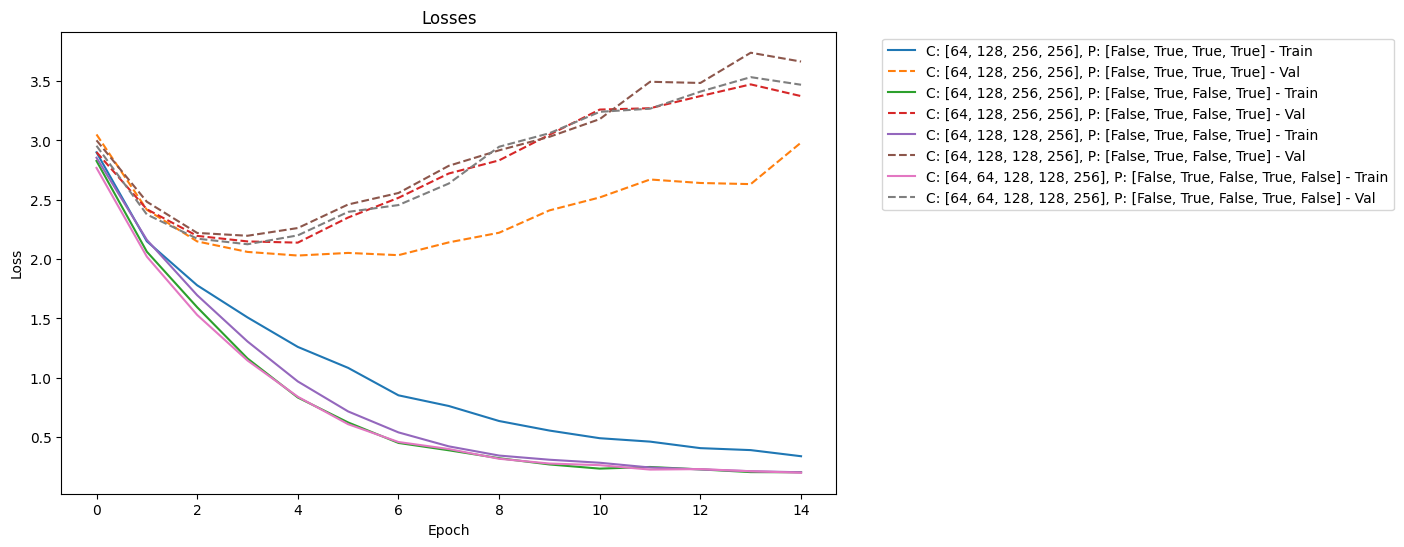

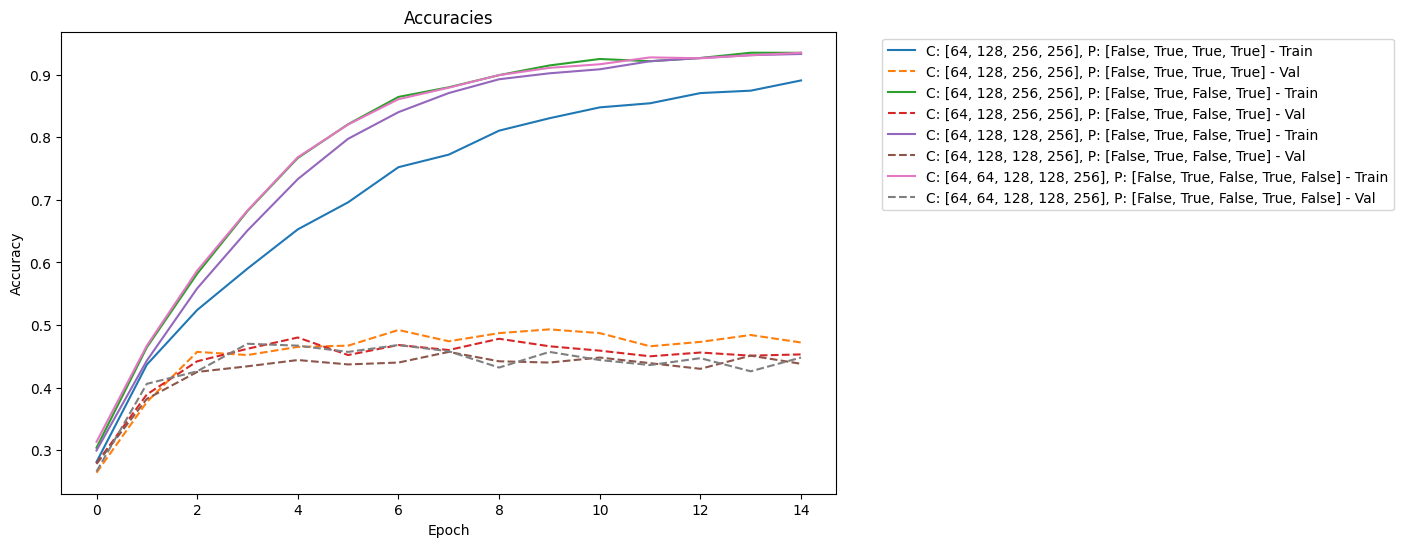

=== Final Evaluation with Best Weights ===
Channels: [64, 128, 256, 256], Pools: [False, True, True, True]
  Train Acc: 88.88%, Val Acc: 45.10%, Test Acc: 48.37%

Channels: [64, 128, 256, 256], Pools: [False, True, False, True]
  Train Acc: 93.40%, Val Acc: 45.70%, Test Acc: 45.04%

Channels: [64, 128, 128, 256], Pools: [False, True, False, True]
  Train Acc: 93.32%, Val Acc: 44.90%, Test Acc: 44.35%

Channels: [64, 64, 128, 128, 256], Pools: [False, True, False, True, False]
  Train Acc: 93.57%, Val Acc: 43.70%, Test Acc: 45.03%



In [16]:
plot_results(results)
evaluate_best_models(results, loader_train, loader_val, loader_test, DEVICE)